<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/main/Hopespeech_indic_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 8.8MB/s 
     |████████████████████████████████| 1.1MB 29.2MB/s 
     |████████████████████████████████| 890kB 41.8MB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=abd2db0ce1a371ef5164e41d61b758cdfeb19ab1221ce8f26b8e53f2714e32d9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
train=pd.read_csv('/content/tamil_hope_first_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,Realme india product,2
1,I also don't have tiktok hello and allnBut I'm...,0
2,Thalaivare..neengale inum one plus mobile vach...,1
3,Annee varanda thondai.. corona virus affect pa...,0
4,5views but 18likes,1
...,...,...
16155,7pm correcta erukum mg bro,0
16156,Intha karutha mudija varaikum Neengalum ellark...,1
16157,And neenga adhiyavasiyam nu soldra apps like t...,1
16158,Daii sekram mater ku vada,0


In [4]:
val=pd.read_csv('/content/tamil_hope_first_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,Mg bro eve 6 o clock video post pannuga,0
1,8.00 pm bro plss,2
2,Bro ivan kitta sonna . Ivan change' pannidava ...,0
3,@Varnajalam Mini Crafts adhum crrct thaan Akka 🤣,1
4,எல்லா குழந்தைகளும் நல்ல எண்ணம்,0
...,...,...
2013,Share karo app use panlama,1
2014,@R SWAGxOP kelattu kapothi maari nee pesathada...,1
2015,Yow yaean yaa kelappi vidringa ipd,1
2016,Hey bro. Ur doing amazing...,2


In [5]:
def punc(df):
    df['tweets'] = df['tweets'].str.replace(r"[+/#@&*$%:]",'')
    print(df)
punc(train)
punc(val)

                                                  tweets  labels
0                                   Realme india product       2
1      I also don't have tiktok hello and allnBut I'm...       0
2      Thalaivare..neengale inum one plus mobile vach...       1
3      Annee varanda thondai.. corona virus affect pa...       0
4                                     5views but 18likes       1
...                                                  ...     ...
16155                         7pm correcta erukum mg bro       0
16156  Intha karutha mudija varaikum Neengalum ellark...       1
16157  And neenga adhiyavasiyam nu soldra apps like t...       1
16158                          Daii sekram mater ku vada       0
16159                             Bro put Redmi 8 gaming       0

[16160 rows x 2 columns]
                                                 tweets  labels
0               Mg bro eve 6 o clock video post pannuga       0
1                                      8.00 pm bro plss       2
2 

In [6]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,tweets,labels,tokenizer,max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self,item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'tweets' : tweets,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels,dtype=torch.long)

    }

In [7]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (16160, 2)
validation set size: (2018, 2)


In [8]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([0.85137769, 0.68428184, 2.74689784])

In [9]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      tweets = df.tweets.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [10]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'ai4bharat/indic-bert'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [11]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [12]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('ai4bharat/indic-bert')
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [14]:
model = RFClassifier(3)
model = model.to(device)

In [15]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
 
#  val_acc,val_loss = eval_model(
#      model,
#      val_data_loader,
#      loss_fn,
#      device,
#      len(val)
#  )

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
 # print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
#  history['val_acc'].append(val_acc)
#  history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
    torch.save(model.state_dict(),'multilingual-bert-base-uncased(25_Epochs).bin')
    best_accuracy = train_acc

Epoch: 01 | Epoch Time: 5m 20s
Train Loss 0.8484545413810428 accuracy 0.5174504950495049

Epoch: 02 | Epoch Time: 5m 39s
Train Loss 0.7775844819474929 accuracy 0.5663985148514852

Epoch: 03 | Epoch Time: 5m 39s
Train Loss 0.7318960667836785 accuracy 0.6186881188118812

Epoch: 04 | Epoch Time: 5m 39s
Train Loss 0.6664660903486875 accuracy 0.6764232673267326

Epoch: 05 | Epoch Time: 5m 39s
Train Loss 0.5883679837283522 accuracy 0.7383044554455446

Epoch: 06 | Epoch Time: 5m 39s
Train Loss 0.5054973417579538 accuracy 0.7923886138613861

Epoch: 07 | Epoch Time: 5m 39s
Train Loss 0.4235572763893864 accuracy 0.8425123762376238

Epoch: 08 | Epoch Time: 5m 38s
Train Loss 0.3551438034170925 accuracy 0.8815594059405941

Epoch: 09 | Epoch Time: 5m 39s
Train Loss 0.2995715363633515 accuracy 0.9116336633663367

Epoch: 10 | Epoch Time: 5m 39s
Train Loss 0.26054042020056506 accuracy 0.9275990099009901



Text(0.5, 0, 'Epoch')

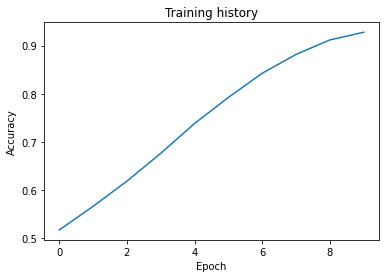

In [27]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend()
#plt.ylim([0, 1]);

In [28]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.5609514370664024

In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweets"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [30]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [31]:
class_name = ['Hope_speech','Non_hope_speech','not-Tamil']

In [32]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                 precision    recall  f1-score   support

    Hope_speech       0.48      0.51      0.49       757
Non_hope_speech       0.61      0.60      0.61       998
      not-Tamil       0.62      0.57      0.59       263

       accuracy                           0.56      2018
      macro avg       0.57      0.56      0.56      2018
   weighted avg       0.56      0.56      0.56      2018



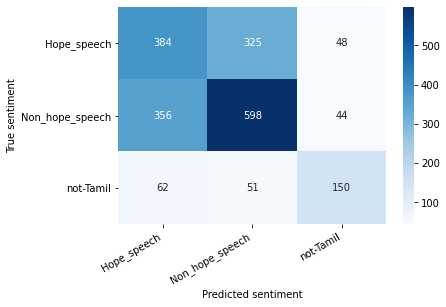

In [33]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)